In [1]:
# IMPORTS #
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import sns
from matplotlib.patches import Patch
import seaborn as sn
from upsetplot import UpSet
from upsetplot import from_indicators

In [2]:
# CONNECT TO DB #

conn = psycopg2.connect(
        dbname="DataChallenge",
        user="dbadmin",  # Full username is required by Azure
        password="BZ6uHRGxki6a7qD",
        host="dcpostgres.postgres.database.azure.com",
        port="5432",
        sslmode="require"  # Mandatory for Azure
    )
print("✅ Connected to Azure PostgreSQL!")

✅ Connected to Azure PostgreSQL!


In [4]:
################ Non reply tweets query #######################

# Query: Non-reply tweets (in_reply_to_status_id is NULL)
non_reply_df = pd.read_sql("""
    SELECT COUNT(*) AS non_reply_tweet_count
    FROM "tweets"
    WHERE in_reply_to_status_id IS NULL;
""", conn)

# Query: Total tweets
total_df = pd.read_sql("""
    SELECT COUNT(*) AS total_tweet_count
    FROM "tweets";
""", conn)

# Extract values
non_reply_count = int(non_reply_df.iloc[0]['non_reply_tweet_count'])
total_count = int(total_df.iloc[0]['total_tweet_count'])
reply_count = total_count - non_reply_count
print(non_reply_count)
print(total_count)
print(reply_count)

C:\Users\User\AppData\Local\Temp\ipykernel_6192\194334973.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  non_reply_df = pd.read_sql("""
C:\Users\User\AppData\Local\Temp\ipykernel_6192\194334973.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  total_df = pd.read_sql("""


4306096
6094135
1788039


In [5]:
######################### Language tweets query #####################

lang_df = pd.read_sql("""
    SELECT lang, COUNT(*) AS tweet_count
    FROM "tweets"
    GROUP BY lang
    ORDER BY tweet_count DESC;
""", conn)
print(lang_df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_6192\1605566894.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lang_df = pd.read_sql("""


  lang  tweet_count
0   en      4413045
1   es       396952
2   fr       263157
3   nl       197734
4  und       180943


In [6]:
##############  Timestamp distribution query #################3

time_df = pd.read_sql("""
    SELECT DATE(created_at) AS day, COUNT(*) AS tweet_count
    FROM "tweets"
    GROUP BY day
    ORDER BY day;
""", conn)
print(time_df.head())


## 
time_df['day'] = pd.to_datetime(time_df['day'])
time_df = time_df.set_index('day')

# Resample to monthly total tweets
monthly_df = time_df.resample('M').sum().reset_index()

C:\Users\User\AppData\Local\Temp\ipykernel_6192\2868415115.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_df = pd.read_sql("""


          day  tweet_count
0  2019-05-22         7894
1  2019-05-23        17534
2  2019-05-24        15696
3  2019-05-25        10877
4  2019-05-26        10240


C:\Users\User\AppData\Local\Temp\ipykernel_6192\2868415115.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = time_df.resample('M').sum().reset_index()


In [7]:
################## Tweet categories query (Extra) ###############
tweet_flags_df = pd.read_sql("""
    SELECT 
        in_reply_to_status_id IS NOT NULL AS is_reply,
        retweeted_status_id IS NOT NULL AS is_retweet,
        is_quote_status IS TRUE AS is_quote
    FROM "tweets"
    TABLESAMPLE SYSTEM (0.001);  -- adjust % here for more rows
""", conn)


C:\Users\User\AppData\Local\Temp\ipykernel_6192\3885644089.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tweet_flags_df = pd.read_sql("""


In [8]:
# Convert to binary indicator matrix
flags_upset_data = from_indicators(
    ["is_reply", "is_retweet", "is_quote"],
    tweet_flags_df
)

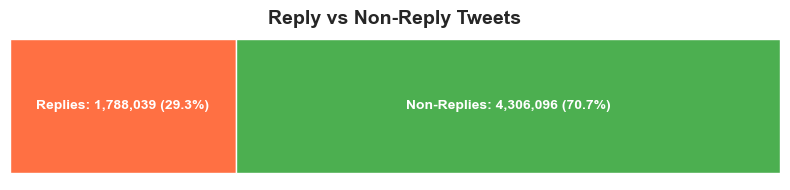

In [9]:
# Reply vs Non-reply
# Prepare data
categories = ['Replies', 'Non-Replies']
values = [reply_count, non_reply_count]
colors = ['#FF7043', '#4CAF50']  # reply = red, non-reply = green

# Plot
plt.figure(figsize=(8, 2))
plt.barh(
    y=0,
    width=values,
    left=[0, values[0]],
    color=colors,
    height=0.5
)

# Labels on bar segments
for i, (v, label) in enumerate(zip(values, categories)):
    percent = f"{v/total_count:.1%}"
    plt.text(
        sum(values[:i]) + v / 2,
        0,
        f"{label}: {v:,} ({percent})",
        ha='center',
        va='center',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

plt.title("Reply vs Non-Reply Tweets", fontsize=14, fontweight='bold')
plt.axis('off')
plt.xlim(0, total_count)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_6192\2375970919.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


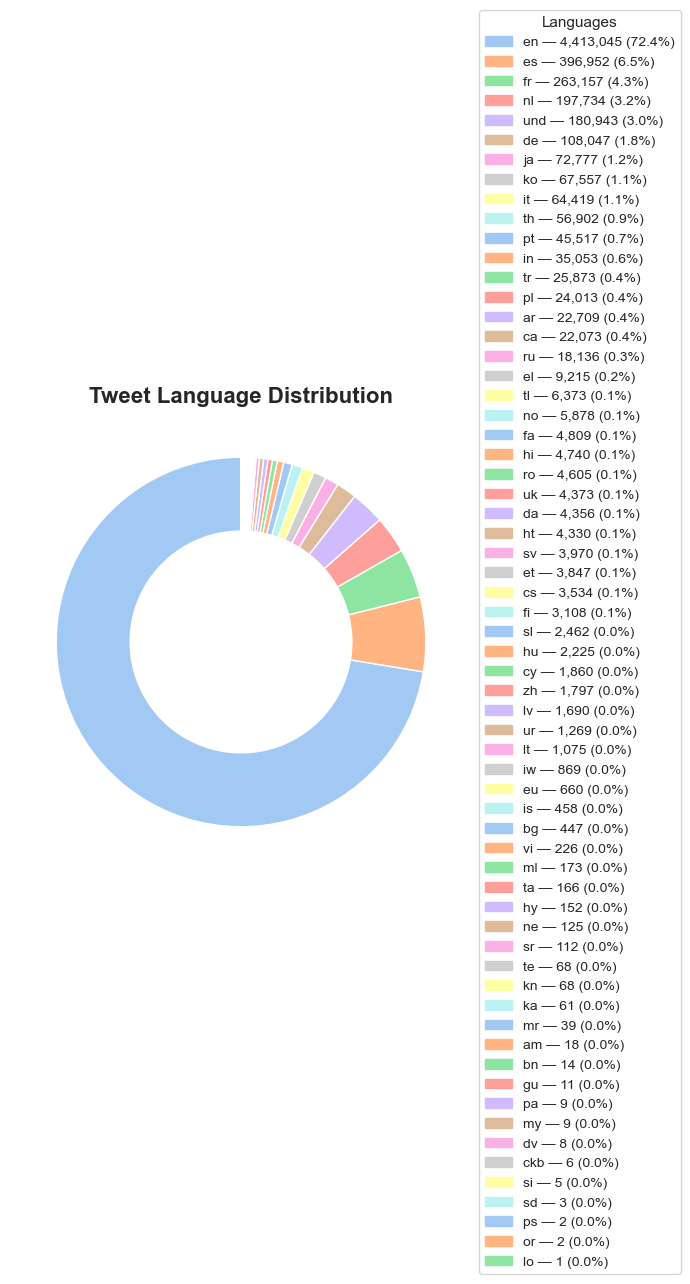

In [16]:
#################### LANGUAGES EDA ##################
# Define color palette
colors = sns.color_palette('pastel', n_colors=len(lang_df))


# Create % and readable legend labels
lang_df['pct'] = lang_df['tweet_count'] / lang_df['tweet_count'].sum()
legend_labels = [
    f"{lang} — {count:,} ({pct:.1%})"
    for lang, count, pct in zip(lang_df['lang'], lang_df['tweet_count'], lang_df['pct'])
]

# Draw donut-style pie
plt.figure(figsize=(7, 6))
wedges, _ = plt.pie(
    lang_df['tweet_count'],
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='w')  # Donut-style
)

# Add external legend
plt.legend(
    handles=[Patch(color=colors[i], label=legend_labels[i]) for i in range(len(lang_df))],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title="Languages",
    title_fontsize=11
)

plt.title("Tweet Language Distribution", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


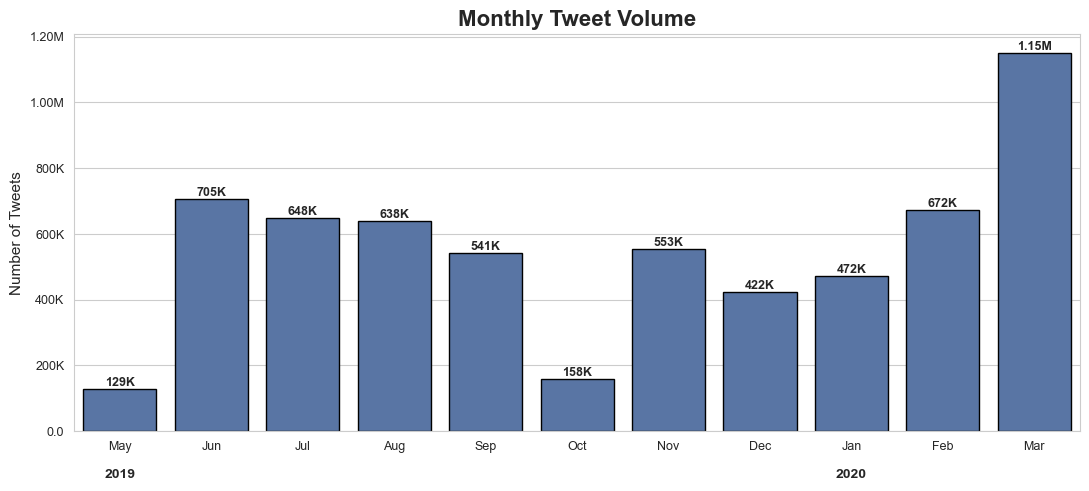

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Create shorthand number formatter: 255000 → 255K, 1,200,000 → 1.2M
def human_format(num):
    if num >= 1_000_000:
        return f"{num/1_000_000:.2f}M"
    elif num >= 1_000:
        return f"{int(num/1_000)}K"
    else:
        return str(num)

# Format x-axis with month only (we'll label year manually)
monthly_df['month_label'] = monthly_df['day'].dt.strftime('%b')  # e.g., "May", "Jun"
years = monthly_df['day'].dt.year.tolist()

plt.figure(figsize=(11, 5))
sns.set_style("whitegrid")

# Bar chart
barplot = sns.barplot(
    data=monthly_df,
    x='month_label',
    y='tweet_count',
    color='#4C72B0',
    edgecolor='black'
)

# Format y-axis ticks with human numbers
barplot.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: human_format(x)))

# Add data labels on top of bars
for bar, val in zip(barplot.patches, monthly_df['tweet_count']):
    barplot.annotate(
        human_format(val),
        (bar.get_x() + bar.get_width() / 2, val),
        ha='center', va='bottom',
        fontsize=9, fontweight='bold'
    )

# Add year labels under May (first entry) and Jan 2020
for i, year in enumerate(years):
    if (i == 0) or (year != years[i - 1]):  # first of each year
        plt.text(i, -0.1 * max(monthly_df['tweet_count']),
                 str(year),
                 ha='center', va='top', fontsize=10, fontweight='bold')

# Clean up
plt.title("Monthly Tweet Volume", fontsize=16, fontweight='bold')
plt.xlabel("")  # no x-axis label
plt.ylabel("Number of Tweets", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


C:\Users\User\anaconda3\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\User\anaconda3\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

<Figure size 1000x600 with 0 Axes>

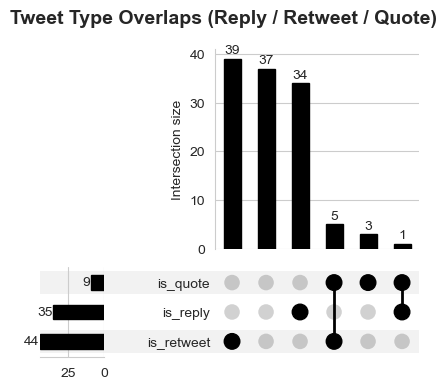

In [12]:
############# UpSet plot - Tweet categories ################

plt.figure(figsize=(10, 6))
UpSet(flags_upset_data, show_counts=True, sort_by='cardinality').plot()
plt.suptitle("Tweet Type Overlaps (Reply / Retweet / Quote)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()